In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 필요한 라이브러리 로드 및 데이터 준비

In [4]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, Bidirectional,AveragePooling2D, LSTM, Reshape ,Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [6]:
data = pd.read_csv('/content/drive/MyDrive/fer2013.csv')

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [7]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [8]:
data.groupby(['emotion']).count()

,pixels,Usage
emotion,,
0,4953,4953
1,547,547
2,5121,5121
3,8989,8989
4,6077,6077
5,4002,4002
6,6198,6198


In [9]:
x_data = data['pixels']
y_data = data['emotion']

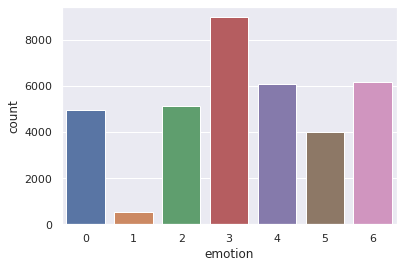

In [10]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

# 1을 빼고 가야할지도...

In [11]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [12]:
y_data.value_counts()

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

In [13]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    69 24 24 37 64 51 52 75 68 56 28 25 49 35 44 5...
62919    73 77 75 71 65 61 89 87 90 96 109 117 137 140 ...
62920    16 16 16 16 17 18 25 50 69 66 69 86 91 88 86 8...
62921    209 204 202 202 173 74 31 37 25 22 21 17 17 17...
62922    28 32 37 41 41 41 44 50 39 98 236 226 191 143 ...
Length: 62923, dtype: object

In [14]:
# 0-1 사이 값으로 정규화
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [15]:
import gc
gc.collect()

0

In [16]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [17]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 0, shuffle=True)

In [19]:
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [20]:
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(6293, 7)

# 학습

## CNN

In [35]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Flatten(),  
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 46, 46, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_11 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 46, 46, 64)       

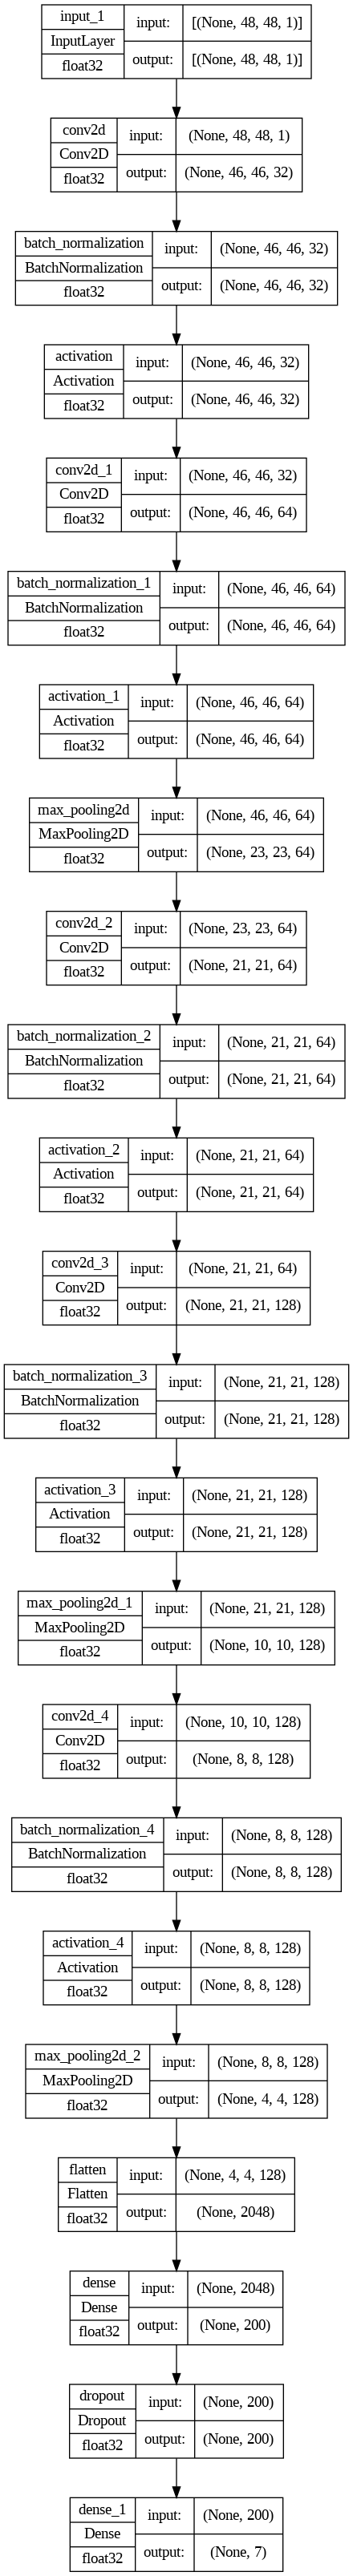

In [22]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

In [23]:
from keras.callbacks import EarlyStopping

In [38]:
adam = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [26]:
history = model.fit(x_train, y_train, 
                    epochs = 100, 
                    validation_data=(x_test, y_test), 
                    callbacks = [early_stopping_callback])

Epoch 1/100
1770/1770 [==============================] - 37s 14ms/step - loss: 1.6388 - accuracy: 0.3625 - val_loss: 1.3444 - val_accuracy: 0.5006
Epoch 2/100
1770/1770 [==============================] - 23s 13ms/step - loss: 1.2541 - accuracy: 0.5196 - val_loss: 1.1077 - val_accuracy: 0.5700
Epoch 3/100
1770/1770 [==============================] - 23s 13ms/step - loss: 1.0841 - accuracy: 0.5817 - val_loss: 1.0072 - val_accuracy: 0.6188
Epoch 4/100
1770/1770 [==============================] - 23s 13ms/step - loss: 0.9777 - accuracy: 0.6246 - val_loss: 0.9400 - val_accuracy: 0.6447
Epoch 5/100
1770/1770 [==============================] - 23s 13ms/step - loss: 0.8840 - accuracy: 0.6630 - val_loss: 0.8809 - val_accuracy: 0.6626
Epoch 6/100
1770/1770 [==============================] - 23s 13ms/step - loss: 0.7942 - accuracy: 0.7020 - val_loss: 0.8166 - val_accuracy: 0.6920
Epoch 7/100
1770/1770 [==============================] - 24s 13ms/step - loss: 0.7106 - accuracy: 0.7335 - val_loss: 0

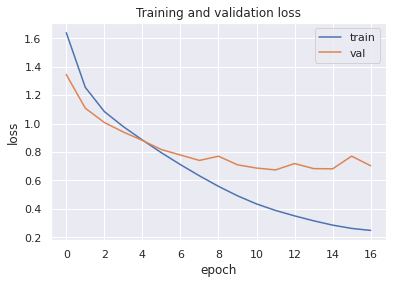

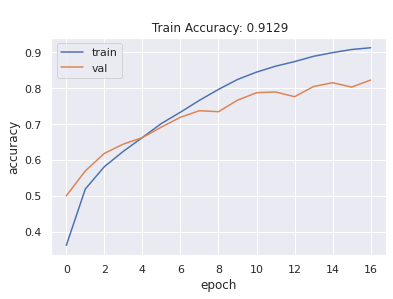

In [29]:
# 그래프
# loss 확인 
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend(['train','val'])
plt.show()
 
 
# accuracy 확인 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("\n Train Accuracy: %.4f" % (0.9129))
plt.legend(['train','val'])
plt.show()

In [31]:
# 모델 저장
model.save('/content/drive/MyDrive/model/cnn_e-17.h5')

- epoch 늘림

In [39]:
history = model.fit(x_train, y_train, 
                    epochs = 50, 
                    validation_data=(x_test, y_test))

Epoch 1/50
1770/1770 [==============================] - 28s 13ms/step - loss: 1.6159 - accuracy: 0.3691 - val_loss: 1.2987 - val_accuracy: 0.5215
Epoch 2/50
1770/1770 [==============================] - 23s 13ms/step - loss: 1.2448 - accuracy: 0.5211 - val_loss: 1.0799 - val_accuracy: 0.5949
Epoch 3/50
1770/1770 [==============================] - 23s 13ms/step - loss: 1.0781 - accuracy: 0.5830 - val_loss: 1.0039 - val_accuracy: 0.6243
Epoch 4/50
1770/1770 [==============================] - 24s 13ms/step - loss: 0.9683 - accuracy: 0.6296 - val_loss: 0.9250 - val_accuracy: 0.6507
Epoch 5/50
1770/1770 [==============================] - 23s 13ms/step - loss: 0.8790 - accuracy: 0.6661 - val_loss: 0.8614 - val_accuracy: 0.6776
Epoch 6/50
1770/1770 [==============================] - 24s 13ms/step - loss: 0.7936 - accuracy: 0.7027 - val_loss: 0.8027 - val_accuracy: 0.7076
Epoch 7/50
1770/1770 [==============================] - 23s 13ms/step - loss: 0.7048 - accuracy: 0.7372 - val_loss: 0.7798 -

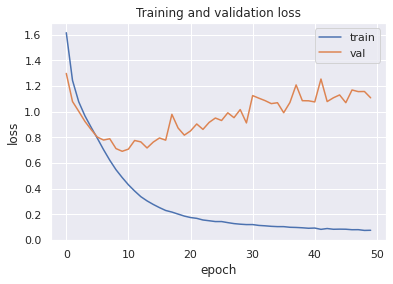

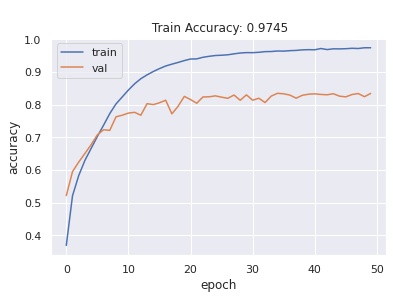

In [41]:
# 그래프
# loss 확인 
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.legend(['train','val'])
plt.show()
 
 
# accuracy 확인 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("\n Train Accuracy: %.4f" % (0.9745))
plt.legend(['train','val'])
plt.show()

In [40]:
# 모델 저장
model.save('/content/drive/MyDrive/model/cnn_e-final.h5')

## CNN + LSTM


- CNN-LSTM 조합모델은 각 기법의 약점을 서로 보완할 수 있 고, 특히 LSTM의 end-to-end를 이용하여 layer 별 로 학습성능을 향상시킬 수 있는 장점
- 이미지의 형태적 특징을 추출하는 CNN과 시퀀스의 시간적 맥락을 기억하는 LSTM 구조를 결합한 신경망이며, 이미지 시퀀스(동영상)의 공간적, 시간적 특징 정보를 한 번에 효과적으로 학습할 수 있다. 
=> 성능 향상을 위해 LSTM 층을 추가해봄

In [ ]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Reshape((-1,128)),
    (LSTM(128)),
    (Reshape((-1,64))),
    LSTM(64),
#     (Reshape((-1,64)))
#     (LSTM(32))    
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 46, 46, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_11 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 46, 46, 64)       

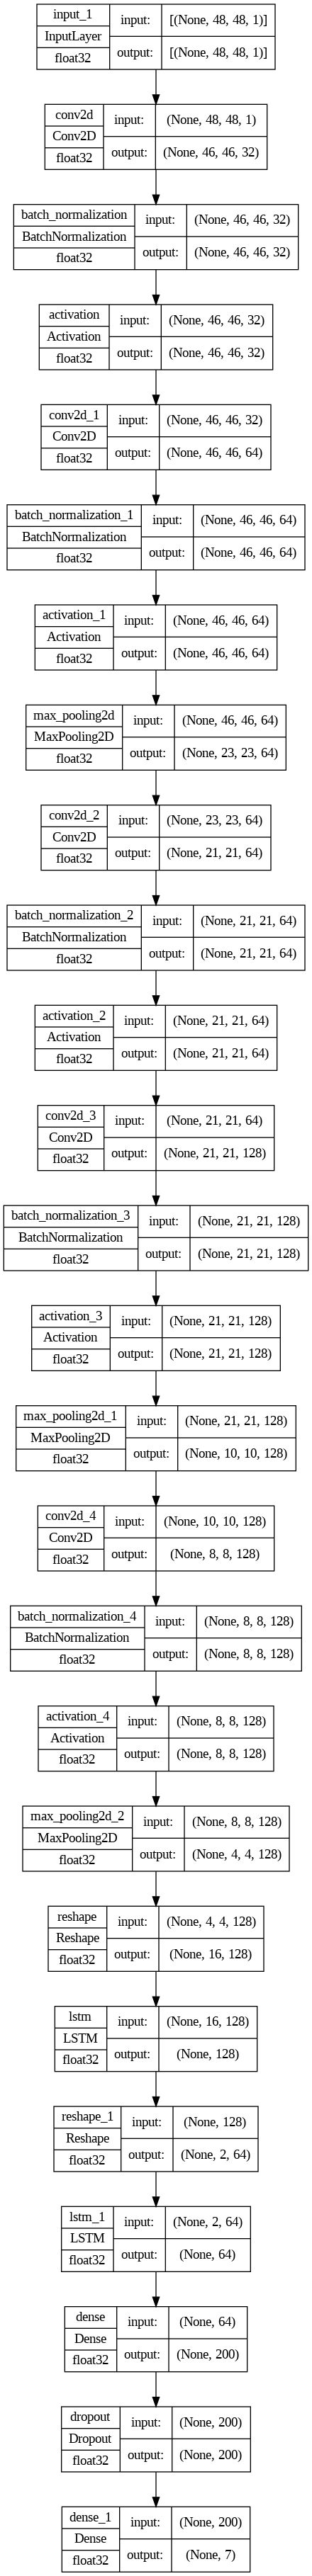

In [ ]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

- Dropout(0.6)
- adam = keras.optimizers.Adam(learning_rate=0.0002)

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs = 100, 
                    validation_data=(x_test, y_test), 
                    callbacks = [early_stopping_callback])

Epoch 1/100
1770/1770 [==============================] - 49s 16ms/step - loss: 1.4663 - accuracy: 0.4272 - val_loss: 1.2462 - val_accuracy: 0.5010
Epoch 2/100
1770/1770 [==============================] - 27s 15ms/step - loss: 1.0551 - accuracy: 0.5944 - val_loss: 1.0116 - val_accuracy: 0.6088
Epoch 3/100
1770/1770 [==============================] - 27s 16ms/step - loss: 0.9030 - accuracy: 0.6594 - val_loss: 0.9408 - val_accuracy: 0.6448
Epoch 4/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.7878 - accuracy: 0.7089 - val_loss: 0.9738 - val_accuracy: 0.6332
Epoch 5/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.6743 - accuracy: 0.7556 - val_loss: 0.8618 - val_accuracy: 0.6916
Epoch 6/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.5782 - accuracy: 0.7948 - val_loss: 0.7791 - val_accuracy: 0.7210
Epoch 7/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.4949 - accuracy: 0.8280 - val_loss: 0

In [ ]:
# 모델 저장
model.save('/content/drive/MyDrive/SK 쉴더스/모듈프젝3/GAN/CNN/model/cnn_lstm_e-15.h5')

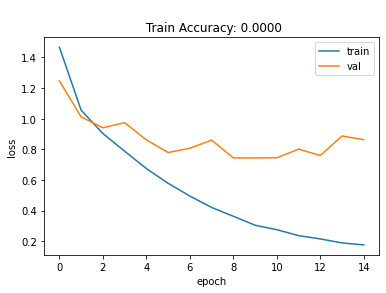

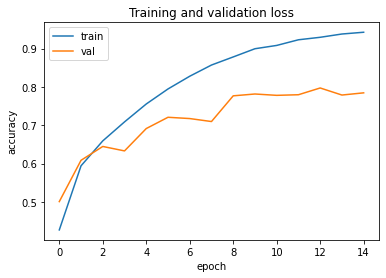

In [ ]:
# 그래프
# loss 확인 
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("\n Train Accuracy: %.4f" % (0))
plt.legend(['train','val'])
plt.show()
 
 
# accuracy 확인 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Training and validation loss')
plt.legend(['train','val'])
plt.show()

- adam = keras.optimizers.Adam(learning_rate=5e-5)
- Dropout(0.2)

In [ ]:
adam = keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs = 100, 
                    validation_data=(x_test, y_test), 
                    callbacks = [early_stopping_callback])

Epoch 1/100
1770/1770 [==============================] - 36s 16ms/step - loss: 1.5768 - accuracy: 0.3897 - val_loss: 1.3790 - val_accuracy: 0.4675
Epoch 2/100
1770/1770 [==============================] - 27s 16ms/step - loss: 1.1307 - accuracy: 0.5600 - val_loss: 1.1552 - val_accuracy: 0.5522
Epoch 3/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.9888 - accuracy: 0.6222 - val_loss: 1.0063 - val_accuracy: 0.6216
Epoch 4/100
1770/1770 [==============================] - 29s 16ms/step - loss: 0.8794 - accuracy: 0.6699 - val_loss: 1.0931 - val_accuracy: 0.5956
Epoch 5/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.7816 - accuracy: 0.7111 - val_loss: 0.9638 - val_accuracy: 0.6426
Epoch 6/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.6912 - accuracy: 0.7483 - val_loss: 1.3791 - val_accuracy: 0.5231
Epoch 7/100
1770/1770 [==============================] - 27s 16ms/step - loss: 0.6121 - accuracy: 0.7812 - val_loss: 1

- adam = keras.optimizers.Adam(learning_rate=0.0001)
- Dropout(0.5)
- early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs = 100, 
                    validation_data=(x_test, y_test), 
                    callbacks = [early_stopping_callback])

Epoch 1/100
1770/1770 [==============================] - 38s 17ms/step - loss: 1.5288 - accuracy: 0.4034 - val_loss: 1.2027 - val_accuracy: 0.5373
Epoch 2/100
1770/1770 [==============================] - 28s 16ms/step - loss: 1.0888 - accuracy: 0.5807 - val_loss: 1.2215 - val_accuracy: 0.5344
Epoch 3/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.9288 - accuracy: 0.6502 - val_loss: 1.0359 - val_accuracy: 0.6070
Epoch 4/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.8061 - accuracy: 0.7034 - val_loss: 1.6742 - val_accuracy: 0.5133
Epoch 5/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.6943 - accuracy: 0.7500 - val_loss: 0.8489 - val_accuracy: 0.6924
Epoch 6/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.5965 - accuracy: 0.7903 - val_loss: 0.9236 - val_accuracy: 0.6849
Epoch 7/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.5080 - accuracy: 0.8243 - val_loss: 0

In [ ]:
# 모델 저장
model.save('/content/drive/MyDrive/SK 쉴더스/모듈프젝3/GAN/CNN/model/cnn_lstm_e-27.h5')

- LSTM 모델층 추가

In [ ]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Reshape((-1,128)),
    (LSTM(128)),
    (Reshape((-1,64))),
    LSTM(64),
    (Reshape((-1,64))),
    (LSTM(32)),    
    Dense(200, activation='relu'),
    Dropout(0.25),
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_17 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 46, 46, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_18 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 46, 46, 64)       

In [ ]:
from keras.callbacks import EarlyStopping

- EarlyStopping(monitor='val_accuracy') 변경

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs = 100, 
                    validation_data=(x_test, y_test), 
                    callbacks = [early_stopping_callback])

Epoch 1/100
1770/1770 [==============================] - 39s 17ms/step - loss: 1.5628 - accuracy: 0.3812 - val_loss: 1.3379 - val_accuracy: 0.4686
Epoch 2/100
1770/1770 [==============================] - 29s 16ms/step - loss: 1.1129 - accuracy: 0.5607 - val_loss: 1.3779 - val_accuracy: 0.5012
Epoch 3/100
1770/1770 [==============================] - 30s 17ms/step - loss: 0.9585 - accuracy: 0.6295 - val_loss: 0.9874 - val_accuracy: 0.6216
Epoch 4/100
1770/1770 [==============================] - 29s 16ms/step - loss: 0.8378 - accuracy: 0.6859 - val_loss: 1.0570 - val_accuracy: 0.6085
Epoch 5/100
1770/1770 [==============================] - 29s 16ms/step - loss: 0.7307 - accuracy: 0.7330 - val_loss: 0.8718 - val_accuracy: 0.6843
Epoch 6/100
1770/1770 [==============================] - 29s 16ms/step - loss: 0.6296 - accuracy: 0.7750 - val_loss: 0.9571 - val_accuracy: 0.6615
Epoch 7/100
1770/1770 [==============================] - 29s 16ms/step - loss: 0.5405 - accuracy: 0.8123 - val_loss: 1

- 다시 층 줄여서...

In [ ]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Reshape((-1,128)),
    (LSTM(128)),
    (Reshape((-1,64))),
    LSTM(64),
#     (Reshape((-1,64)))
#     (LSTM(32))    
    Dense(200, activation='relu'),
    Dropout(0.5),
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_37 (Bat  (None, 46, 46, 32)       128       
 chNormalization)                                                
                                                                 
 activation_37 (Activation)  (None, 46, 46, 32)        0         
                                                                 
 conv2d_39 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_38 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 activation_38 (Activation)  (None, 46, 46, 64)       

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs = 100, 
                    validation_data=(x_test, y_test),
                    callbacks = [early_stopping_callback])

Epoch 1/100
1770/1770 [==============================] - 36s 16ms/step - loss: 1.5168 - accuracy: 0.4072 - val_loss: 1.2632 - val_accuracy: 0.4969
Epoch 2/100
1770/1770 [==============================] - 28s 16ms/step - loss: 1.0839 - accuracy: 0.5825 - val_loss: 1.0608 - val_accuracy: 0.5778
Epoch 3/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.9278 - accuracy: 0.6492 - val_loss: 0.9640 - val_accuracy: 0.6301
Epoch 4/100
1770/1770 [==============================] - 27s 15ms/step - loss: 0.8035 - accuracy: 0.7046 - val_loss: 0.9731 - val_accuracy: 0.6248
Epoch 5/100
1770/1770 [==============================] - 27s 15ms/step - loss: 0.6891 - accuracy: 0.7556 - val_loss: 0.8908 - val_accuracy: 0.6584
Epoch 6/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.5873 - accuracy: 0.7963 - val_loss: 0.9275 - val_accuracy: 0.6658
Epoch 7/100
1770/1770 [==============================] - 28s 16ms/step - loss: 0.4960 - accuracy: 0.8308 - val_loss: 0

In [ ]:
# 모델 저장
model.save('/content/drive/MyDrive/SK 쉴더스/모듈프젝3/GAN/CNN/model/cnn_lstm_e-final.h5')

=> 여기선 LSTM을 합한게 없을 때보다 더 좋은지는 모르겠음

**- 최종 cnn_e-17.h5 이용**

[참고](https://www.kaggle.com/code/anushkakalwale/fer2013-cnn-lstm)